## Introduction
#### This notebook serves as the sandbox where the necessary scripting for creating a fasterRCNN model with CRES simulated data was figured out. It contains the first simulations with boundary box outputs, and the pytorch Dataset and DataModule needed to fit a small batch of the simulated data produced. Once it was demonstrated to be working to first order, the script `fasterRCNN_ds.py` was made in order to run the simulation from the command line for use in larger scale training. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
import sys
import yaml
from pathlib import Path
import shutil
import json

sys.path.append(sys.path[0]+'/..')
from he6_cres_deep_learning.daq import DAQ, Config

## Creating Boundary Box outputs in a CRES simulation

#### Function to create the DataFrame of files/events and target boundary boxes

In [2]:
def fasterrcnn_df(n_files, n_events_per_file, spec_length=.035, freq_bw=1200e6, slope_mean=2e8, slope_std=1e7, seed=1234):
    '''
    Define the DataFrame describing the simulation of various events over several spec files. Entries are track-level description of
    the electron's motion in the CRES apparatus. As of now there are still unphysical aspects to the simulation, but the important piece 
    is the inclusion of the boundary boxes as an output.
    Returns a DataFrame of the track information and the boundary boxes in dictionary format. Also returns track-level boundary boxes for
    visualization and error-checking purposes.
    '''
    
    # Use the format first defined by Drew for structure of sim data
    track_set = {
            "file_in_acq": [],
            "event_num": [],
            "time_start": [],
            "time_stop": [],
            "freq_start": [],
            "freq_stop": [],
            "slope": [],
            "band_power_start": [],
            "band_power_stop": [],
            "band_num": [],
        }
    
    # Dictionary to store event boundary boxes for each file
    event_bboxes = {
        0: # key will be file number
            {0: # value will be a dict, where key is event number (this will grow through sim)
                 []} # value of the inner dict will be the boundary box coordinates 
                     # in format [start_time, start_freq, stop_time, stop_freq]
    }
    
    # Define Generator object for pulling from distributions
    rng = np.random.default_rng(seed)
    
    # n_events in a spec file can be reasonably estimated from a Poisson distribution
    n_events = rng.poisson(lam=3, size=n_files) 
    # don't want files with 0 events
    n_events += 1
    
    # Loop over files
    for file, events in enumerate(n_events): 
        # check if file in keys for bboxes, if not then initialize dict
        if file not in event_bboxes.keys():
            event_bboxes[file] = {0: []}

        # Pull from uniform distribution to determine start time of event
        event_start_times = rng.uniform(low=0, high=spec_length, size=events)
        
#-------------------------------------------------------------------------------------------------------------------------
        # Get start frequencies
        # TODO: implement beta spectrum sampling for start frequencies
        event_start_frequencies = rng.uniform(low=150e6, high=freq_bw, size=events)
#-------------------------------------------------------------------------------------------------------------------------

        # Loop over each event in file
        for event, (start_time, start_freq) in enumerate(zip(event_start_times, event_start_frequencies)):
            # check if event in keys for bboxes, if not then initialize list
            if event not in event_bboxes[file].keys():
                event_bboxes[file][event] = []
                
#-------------------------------------------------------------------------------------------------------------------------
            # Define number of scatters per event
            # TODO: Implement a physical model for scattering
            n_tracks = rng.integers(low=1, high = 10)
#-------------------------------------------------------------------------------------------------------------------------

            # Loop over each track in event
            for track in range(n_tracks):
                # Defining break parameter if need to leave loop because we hit edge of spec file
                _break = False
                
                # Pull track length from exponential distribution with tau=10ms
                track_len = rng.exponential(scale=.01)
                
                # Check to see if track outside of time window
                if start_time+track_len > spec_length:
                    stop_time = spec_length
                    track_len = spec_length-start_time
                    _break = True
                else:
                    stop_time = start_time+track_len
    
#-------------------------------------------------------------------------------------------------------------------------
                # Slope of track is assumed to be normally distributed around the mean of 2e8Hz in Kr83 events
                # TODO: Implement empirical model for track slopes based on energy of the electron
                slope = rng.normal(loc=slope_mean, scale=slope_std)
#-------------------------------------------------------------------------------------------------------------------------
                
                # Check if track outside of bandwidth
                if start_freq + slope*track_len > freq_bw:
                    stop_freq = freq_bw
                    _break = True
                else:
                    stop_freq = start_freq+slope*track_len

                # Store parameters in dict
                track_set["file_in_acq"].append(file)
                track_set["event_num"].append(event)
                track_set["time_start"].append(start_time)
                track_set["time_stop"].append(stop_time)
                track_set["slope"].append(slope)
                track_set["freq_start"].append(start_freq)
                track_set["freq_stop"].append(stop_freq)
                
                # If first track in event, add start_time, start_freq to bboxes dict
                if track==0:
                    event_bboxes[file][event].append(start_time)
                    event_bboxes[file][event].append(start_freq)
                
                # If hit edge then break out of track loop for this event, append bbox values
                if _break:
                    event_bboxes[file][event].append(stop_time)
                    event_bboxes[file][event].append(stop_freq)
                    break
                
                # If reached number of tracks in event then append bbox values
                elif track==n_tracks-1:
                    event_bboxes[file][event].append(stop_time)
                    event_bboxes[file][event].append(stop_freq)
                
#-------------------------------------------------------------------------------------------------------------------------
                # Else update start time and freq. 
                # Frequency jump will be pulled from normal dist mean 10MHZ std 2MHz
                # TODO: Frequency jumps will also have to be pulled from physical scattering model
                else:
                    start_time = stop_time
                    start_freq = stop_freq + rng.normal(loc=10e6, scale=2e6)
#-------------------------------------------------------------------------------------------------------------------------
    
#-------------------------------------------------------------------------------------------------------------------------   
    # TODO: implement proper power information
    track_set["band_power_start"] = [1e-14]*len(track_set["slope"])
    track_set["band_power_stop"] = [1e-14]*len(track_set["slope"])
    track_set["band_num"] = np.zeros(len(track_set["slope"]))
#-------------------------------------------------------------------------------------------------------------------------
    
    # convert track_set dict to DataFrame
    track_set = pd.DataFrame(track_set)
    
    # define track bbox DataFrame
    track_bboxes = track_set.loc[:,("file_in_acq", "event_num")].copy()
    bbox_list = []
    
    # define counter to keep up with total tracks for indexing
    tot_tracks=0
    for file in event_bboxes.keys():
        for event in event_bboxes[file].keys():
            n_tracks = track_set[(track_set["file_in_acq"]==file) &\
                                 (track_set["event_num"]==event)].shape[0]
            for track in range(n_tracks):
                bbox_list.append(event_bboxes[file][event])
                if track==n_tracks-1:
                    tot_tracks += n_tracks
                    
    track_bboxes['bbox'] = bbox_list

    return track_set, track_bboxes, event_bboxes

## EDA (sanity checking the simulation)

In [3]:
track_df, bboxes, bboxes_dict = fasterrcnn_df(1000,3)

In [4]:
track_df.head()

,file_in_acq,event_num,time_start,time_stop,freq_start,freq_stop,slope,band_power_start,band_power_stop,band_num
0,0,0,0.022446,0.024955,6.764829e+08,6.769901e+08,2.020995e+08,1.000000e-14,1.000000e-14,0.0
1,0,0,0.024955,0.035000,6.873712e+08,6.893707e+08,1.990581e+08,1.000000e-14,1.000000e-14,0.0
2,0,1,0.006399,0.023035,1.172086e+09,1.175451e+09,2.022679e+08,1.000000e-14,1.000000e-14,0.0
3,0,1,0.023035,0.027329,1.184342e+09,1.185237e+09,2.083806e+08,1.000000e-14,1.000000e-14,0.0
4,0,2,0.032537,0.035000,8.871375e+08,8.876496e+08,2.079502e+08,1.000000e-14,1.000000e-14,0.0


In [5]:
bboxes.head(5)

,file_in_acq,event_num,bbox
0,0,0,"[0.022445951135104024, 676482927.7811224, 0.03..."
1,0,0,"[0.022445951135104024, 676482927.7811224, 0.03..."
2,0,1,"[0.006398810424519579, 1172086133.3575711, 0.0..."
3,0,1,"[0.006398810424519579, 1172086133.3575711, 0.0..."
4,0,2,"[0.03253736927410235, 887137532.9909794, 0.035..."


#### Let's make sure the `file_in_acq` and `event_num` columns match

In [6]:
(track_df['file_in_acq'] != bboxes['file_in_acq']).sum(),\
(track_df['event_num'] != bboxes['event_num']).sum()

(0, 0)

#### Check that we are within the spectrogram limits provided as defaults

In [7]:
track_df['time_stop'].max(),track_df['freq_stop'].max()/1e6

(0.035, 1200.0)

#### Make sure distributions of the columns make sense

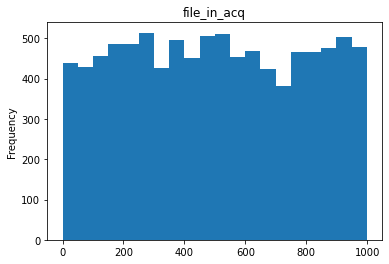

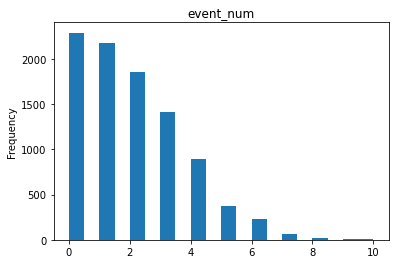

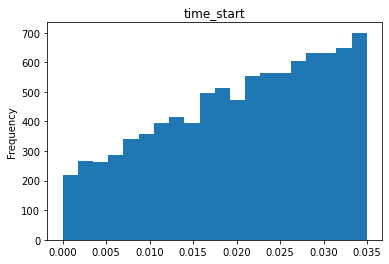

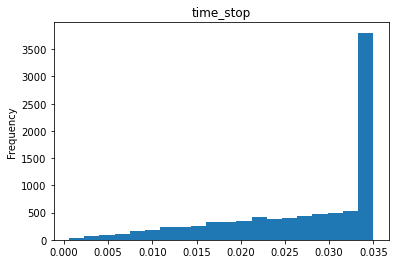

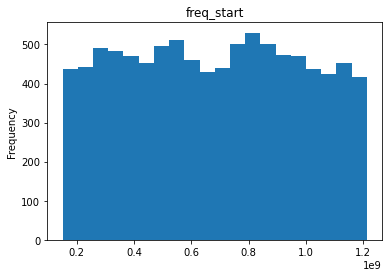

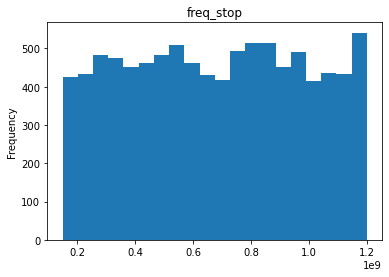

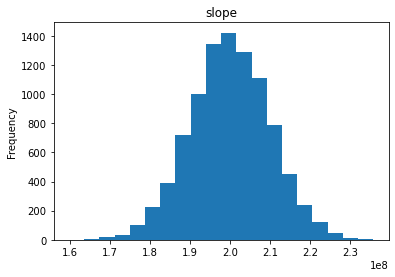

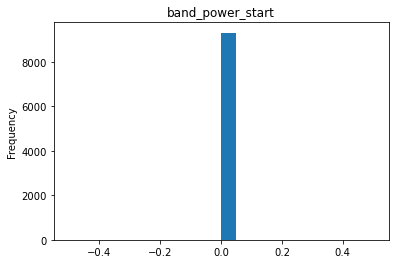

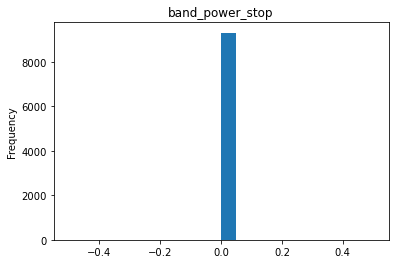

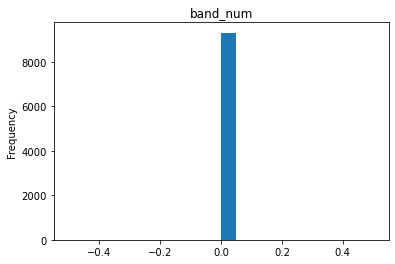

In [8]:
for column in track_df.columns:
    track_df[column].plot(kind='hist', title=column, bins=20)
    plt.show()

Everything looks good up to here. Note that the increasing trend in `time_start` and `time_stop` is reasonable because of scattering present in the simulation which defines the beginning of a new track.

### Plotting tracks and bboxes

In [9]:
def plot_tracks_and_bboxes(tracks, file_in_acq, freq_bw, bbox_list=[]):
    '''
    Given the tracks df and file number you wish to look at will plot the tracks in the file and optionally
    overlay the boundary boxes for the events.
    '''
    condition = tracks.file_in_acq == file_in_acq

    fig, ax = plt.subplots(figsize=(12, 8))

    for index, row in tracks[condition].iterrows():

        time_coor = np.array([row["time_start"], row["time_stop"]])
        freq_coor = np.array([row["freq_start"], row["freq_stop"]])

        ax.plot(
            time_coor,
            freq_coor,
            "ro-",
            markersize=0.5,
            alpha=0.5,
        )
    ax.set_ylim(0, freq_bw)
    ax.set_title("tracks")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Freq (Hz)")
    
    if len(bbox_list):
        bbox_list = bbox_list[bbox_list['file_in_acq']==file_in_acq]['bbox'].values
        for bbox in bbox_list:
            width = bbox[2]-bbox[0]
            height = bbox[3]-bbox[1]
            ax.add_patch(Rectangle(bbox[:2], width, height, alpha=.1))
    plt.show()

    return None

#### Define a random number to look at several files

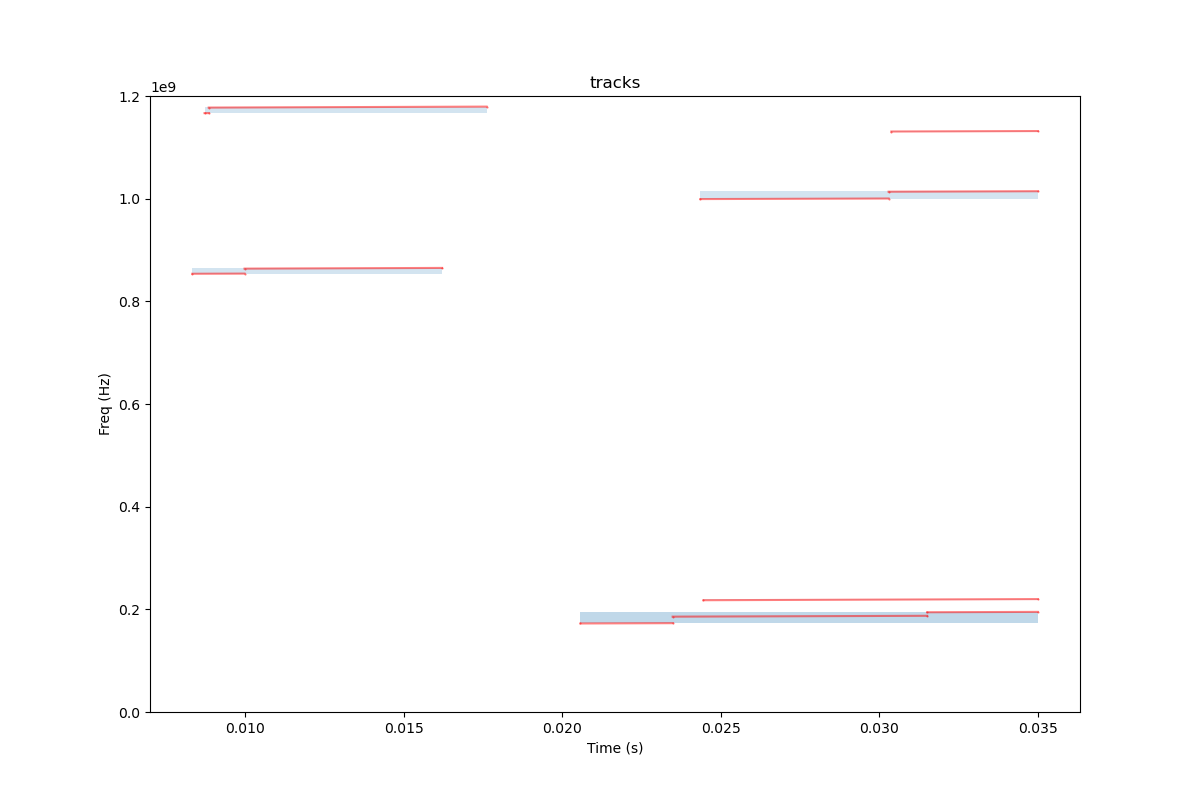

In [22]:
%matplotlib widget
rand_num = np.random.randint(low=1, high=1000)
plot_tracks_and_bboxes(track_df, rand_num, 1200e6, bboxes)

From what I've seen everything looks great!

## Spec file generation
#### Now the information in the track DataFrame will be passed on to the simulation that transforms it into the spectrogram image that is seen in the CRES experiment. Testing the output here to verify it works, as well as create the appropriate transformation for the boundary boxes. Replicating some of the functions from `daq.py` here for testing.

In [11]:
def congifure_gain_noise_csv_simple(csv_path):
    """
    Note that if you don't change the noise here you will end up with the default noise
    floor of the apparatus (I-side).
    """
    # Sinusoidal gain:
    col = "gain"

    array = np.array([1.0] * 4096)
    update_gain_noise_csv(csv_path, col, array)

    # Flat noise:
    col = "noise_mean"

    array = np.array([1.0] * 4096)

    update_gain_noise_csv(csv_path, col, array)

def update_gain_noise_csv(csv_path, col, array):
    """
    Helper function for editing gain_noise.csv.
    """
    noise_gain_df = pd.read_csv(csv_path)
    noise_gain_df[col] = array
    noise_gain_df.to_csv(csv_path, index=False)

    return None

#### sys.path[0] will always give the current directory, so base config paths will just be appended to this. 

In [12]:
base_path = sys.path[0]
# ---- Copy and rename base config ----
name = "fasterRCNN_test"
config_path = base_path + '/config/base_daq_config.yaml'
config_path = Path(config_path)
config_path_test = config_path.with_name(name + config_path.suffix)
shutil.copyfile(str(config_path), str(config_path_test))

'/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/config/fasterRCNN_test.yaml'

In [13]:
# ---- Copy then alter base noise_gain file to make it simpler. ----
# Step 0: make a copy of the gain noise file.
gain_noise_path = base_path + '/gain_noise/base_gain_noise.csv'
gain_noise_path = Path(gain_noise_path)
gain_noise_path_test = gain_noise_path.with_name(
    gain_noise_path.stem + f"_{name}" + gain_noise_path.suffix
)
shutil.copyfile(str(gain_noise_path), str(gain_noise_path_test))

'/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/gain_noise/base_gain_noise_fasterRCNN_test.csv'

In [14]:
# Step 1: alter the gain_noise file.
congifure_gain_noise_csv_simple(gain_noise_path_test)

# ---- Build spec files ----
config = Config(config_path_test)
config.daq

{'spec_length': 0.035,
 'freq_bw': 1200000000.0,
 'freq_bins': 4096,
 'roach_avg': 2,
 'requant_gain': 20,
 'base_gain': 100000000000.0,
 'rng_seed': 123456,
 'build_labels': False,
 'waveguide_side"': 'I',
 'gain_noise_csv_path': '/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/demo/gain_noise/base_gain_noise.csv',
 'spec_prefix': 'test'}

In [15]:
# Change default settings of config to match input args.
config.daq.gain_noise_csv_path = gain_noise_path_test
config.daq.spec_length = 0.035
config.daq.spec_prefix = 'clean_test'
config.daq

{'spec_length': 0.035,
 'freq_bw': 1200000000.0,
 'freq_bins': 4096,
 'roach_avg': 2,
 'requant_gain': 20,
 'base_gain': 100000000000.0,
 'rng_seed': 123456,
 'build_labels': False,
 'waveguide_side"': 'I',
 'gain_noise_csv_path': PosixPath('/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/gain_noise/base_gain_noise_fasterRCNN_test.csv'),
 'spec_prefix': 'clean_test'}

In [16]:
# Extract necessary parameters from config.
spec_length = config.daq.spec_length
freq_bw = config.daq.freq_bw

# Build the track set to be simulated.
tracks, _, target_dict = fasterrcnn_df(
    n_files=5, n_events_per_file=3
)

tracks.head()

,file_in_acq,event_num,time_start,time_stop,freq_start,freq_stop,slope,band_power_start,band_power_stop,band_num
0,0,0,0.023929,0.035000,6.108992e+08,6.131420e+08,2.025884e+08,1.000000e-14,1.000000e-14,0.0
1,0,1,0.023493,0.031908,7.092248e+08,7.106981e+08,1.750821e+08,1.000000e-14,1.000000e-14,0.0
2,0,1,0.031908,0.035000,7.189449e+08,7.195236e+08,1.871687e+08,1.000000e-14,1.000000e-14,0.0
3,0,2,0.021386,0.023938,1.532889e+08,1.537930e+08,1.975278e+08,1.000000e-14,1.000000e-14,0.0
4,0,2,0.023938,0.035000,1.603936e+08,1.625729e+08,1.970036e+08,1.000000e-14,1.000000e-14,0.0


In [17]:
# Build the simulated spec files.
daq = DAQ(config)
daq.run(tracks)

/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/config
Building spec file 0. 0.035 s, 5126 slices.
file = 0, slices = [0:400]
file = 0, slices = [400:800]
file = 0, slices = [800:1200]
file = 0, slices = [1200:1600]
file = 0, slices = [1600:2000]
file = 0, slices = [2000:2400]
file = 0, slices = [2400:2800]
file = 0, slices = [2800:3200]
file = 0, slices = [3200:3600]
file = 0, slices = [3600:4000]
file = 0, slices = [4000:4400]
file = 0, slices = [4400:4800]
file = 0, slices = [4800:5126]
Time to build file 0: 18.573 s 

Building spec file 1. 0.035 s, 5126 slices.
file = 1, slices = [0:400]
file = 1, slices = [400:800]
file = 1, slices = [800:1200]
file = 1, slices = [1200:1600]
file = 1, slices = [1600:2000]
file = 1, slices = [2000:2400]
file = 1, slices = [2400:2800]
file = 1, slices = [2800:3200]
file = 1, slices = [3200:3600]
file = 1, slices = [3600:4000]
file = 1, slices = [4000:4400]
file = 1, slices = [4400:4800]
file = 1, slices = [4800:5126]
Ti

#### The DAQ ran and made some spec files. Let's make sure that the bboxes can be written to disk as well.

In [18]:
def write_label_files(target_dict, path_to_target_dir, spec_prefix):
    if not path_to_target_dir.is_dir():
        path_to_target_dir.mkdir()
        print("created directory : ", path_to_target_dir)
    with open(f'{path_to_target_dir}/{spec_prefix}_labels.json', 'w') as file:
        json.dump(target_dict, file)

In [19]:
labels_path = config_path.parent.joinpath(name, 'label_files')
write_label_files(target_dict, labels_path, config.daq.spec_prefix)

#### Ok, got some json files with bboxes. Let's check the spec files then move on.

In [20]:
spec_path = daq.spec_file_paths[0]
spec_array = daq.spec_to_array(spec_path, slices = -1)

(5126, 4096)


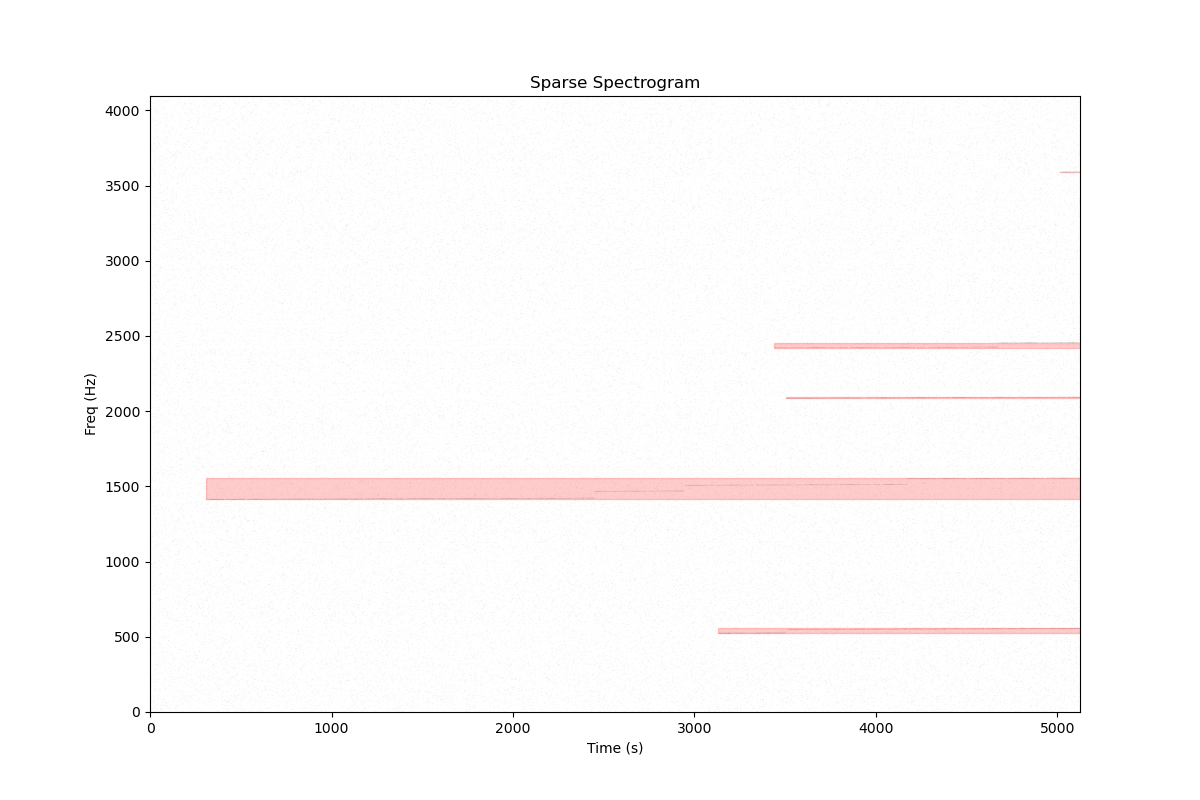

In [21]:
%matplotlib widget

cut_condition = np.array((spec_array > spec_array.mean(axis=0)*5).T , dtype = float)

fig, ax = plt.subplots(figsize=(12,8))

ax.imshow(1-cut_condition,origin='lower', aspect='auto', interpolation=None, cmap = "gray")

for bbox in target_dict[0].values():
    t1 = bbox[0] * config.daq.freq_bw / config.daq.freq_bins / config.daq.roach_avg
    f1 = bbox[1] *  config.daq.freq_bins/config.daq.freq_bw
    width = (bbox[2]-bbox[0]) * config.daq.freq_bw / config.daq.freq_bins / config.daq.roach_avg
    height = (bbox[3]-bbox[1]) * config.daq.freq_bins/config.daq.freq_bw
    ax.add_patch(Rectangle([t1,f1], width, height, alpha=.2, color='red'))

ax.set_title("Sparse Spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Freq (Hz)")
plt.show()

After having to do the annoying conversion to pixel width height for the bboxes, things are looking good. 

#### That will be all that is done in this notebook. I have adapted the simulation to the needs of the fasterRCNN model, and confirmed that it works in terms of producing the information I need. There is still much work to be done to get the modeling done, but that will be done in another notebook. I will produce a script based off the work in this notebook that will allow one to generate many spec files from the command line, which I will do on an AWS instance. Unfortunately, I will need to write the pixel-level information for the bboxes to disk, because after the simulation script is run the modeling won't necessarily have access to the full info. This will be done in the script `fasterRCNN_ds.py`.

In [24]:
# Standard imports
import numpy as np
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
import sys
import yaml
from pathlib import Path
import shutil
import json
from typing import List, Union
import gc
import zipfile
from pathlib import Path
import re

# Deep learning imports.
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset

import torchvision
from torchvision.utils import draw_bounding_boxes, make_grid
from torchvision.ops import masks_to_boxes, box_area
import torchvision.transforms.functional as TF
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision, compute_area

# Additional settings.
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

sys.path.append(sys.path[0]+'/..')
from he6_cres_deep_learning.daq import DAQ, Config
root_dir = sys.path[0]+'/config/fasterRCNN'

## PyTorch-Lightning DataModule

#### Start with getting a Dataset

In [25]:
class CRES_Dataset(torch.utils.data.Dataset):
    """DOCUMENT."""

    def __init__(
        self, root_dir, freq_bins=4096, max_pool=3, file_max=10, transform=None
    ):
        """
        Args:
            root_dir (string): Directory with all the spec files and targets.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.root_dir = root_dir
        self.freq_bins = freq_bins
        self.max_pool = max_pool
        self.file_max = file_max
        self.transform = transform

        self.imgs, self.targets = self.collect_imgs_and_targets()

        # Guarentee the correct type.
        self.imgs = self.imgs.type(torch.ByteTensor)
        # , self.targets = , self.targets.long()

        # Targets don't need the color dimension.
        # self.targets = self.targets.squeeze(1)

        return None

    def __getitem__(self, idx):

        img = self.imgs[idx]
        target = self.targets[idx]

        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):

        return len(self.imgs)

    def collect_imgs_and_targets(self):

        img_dir = self.root_dir + "/spec_files"
        target_dir = self.root_dir + "/label_files"

        # TODO: make it so directories get spec_prefix instead of files
        imgs, exp_name = self.load_spec_dir(img_dir)
#---------------------------------------------------------------------------------------------------        
        # Is this really the best way to scale the bboxes?
        targets = self.load_target_dir(target_dir, exp_name, imgs[0][0].shape)
        # targets = targets.long()

        return imgs, targets

    def load_spec_dir(self, dir_path):
        """
        Loads all of the images in a directory into torch images.

        Args:
            dir_path (str): path should point to a directory that only contains
                .JPG images. Or any image type compatible with cv2.imread().

            resize_factor (float): how to resize the image. Often one would
                like to reduce the size of the images to be easier/faster to
                use with our maskrcnn model.

        Returns:
            imgs (List[torch.ByteTensor[3, H, W]]): list of images (each a
                torch.ByteTensor of shape(3, H, W)).
        """
        path_glob = Path(dir_path).glob("**/*")
        files = [x for x in path_glob if x.is_file()]
        file_names = [str(x.name) for x in files]
        files = [str(x) for x in files]
        
        # extract experiment name to match to target file 
        exp_name = list(set(re.findall(r'[a-zA-Z0-9]+', name)[0] for name in file_names))
        
        # Extract the file index from the file name.
        file_idxs = [int(re.findall(r"\d+", name)[0]) for name in file_names]

        # Sort the files list based on the file_idx.
        files = [
            file
            for (file, file_idx) in sorted(
                zip(files, file_idxs), key=lambda pair: pair[1]
            )
        ]

        # Maxpool to use on images and labels.
        maxpool = nn.MaxPool2d(self.max_pool, self.max_pool, return_indices=False)

        if len(files) == 0:
            raise UserWarning("No files found at the input path.")

        imgs = []
        for file in files[: self.file_max]:

            img = self.spec_to_numpy(file)
            img = torch.from_numpy(img).unsqueeze(0)
            img = img.permute(0, 2, 1)

            # Apply max pooling now so we never have to hold the large images.

            imgs.append(maxpool(img.float()))

        imgs = torch.stack(imgs)

        return imgs, exp_name
    
    def load_target_dir(self, dir_path, exp_name, spec_shape): # spec_shape[0] is frequency, spec_shape[1] is time
        """
        TODO: Document
        Load bbox json files
        """
        path_glob = Path(dir_path).glob(f"{exp_name}*")
        files = [x for x in path_glob if x.is_file()]
        files = [str(x) for x in files]

        if len(files) == 0:
            raise UserWarning("No files found at the input path.")
        
        # targets will be a list of dicts that contain the bboxes, labels, and scores
        targets = []
        targets_dict = {'boxes': [],
                        'labels': []}
        for file in files[: self.file_max]:
            # read all bboxes for experiment
            with open(file, 'r') as f:
                bboxes = json.load(f)
                
                # each value corresponds to a file number
                for file_num, bbox_dict in bboxes.items():
                    # make sure we've populated the dict at least once before appending to list
                    if file_num != '0':
                        targets.append(targets_dict)
                        targets_dict = {'boxes': [],
                                        'labels': []}
                        
                    # each bbox corresponds to an event in the file
                    for bbox in bbox_dict.values():
                        targets_dict['boxes'].append(torch.tensor(bbox))
                        targets_dict['labels'].append(torch.tensor([1]))
                        
        targets.append(targets_dict)
        targets_dict = {'boxes': [],
                        'labels': []}
        for target in targets:
            target['boxes'] = torch.stack(target['boxes'])
            target['labels'] = torch.tensor(target['labels'])
        return targets
        

    def spec_to_numpy(
        self, spec_path, slices=-1, packets_per_slice=1, start_packet=None
    ):
        """
        TODO: Document.
        Making this just work for one packet per spectrum because that works for simulation in Katydid.
        * Make another function that works with 4 packets per spectrum (for reading the Kr data).
        """

        BYTES_IN_PAYLOAD = self.freq_bins
        BYTES_IN_HEADER = 32
        BYTES_IN_PACKET = BYTES_IN_PAYLOAD + BYTES_IN_HEADER

        if slices == -1:
            spec_array = np.fromfile(spec_path, dtype="uint8", count=-1).reshape(
                (-1, BYTES_IN_PACKET)
            )[:, BYTES_IN_HEADER:]
        else:
            spec_array = np.fromfile(
                spec_path, dtype="uint8", count=BYTES_IN_PAYLOAD * slices
            ).reshape((-1, BYTES_IN_PACKET))[:, BYTES_IN_HEADER:]
        
        if packets_per_slice > 1:

            spec_flat_list = [
                spec_array[(start_packet + i) % packets_per_slice :: packets_per_slice]
                for i in range(packets_per_slice)
            ]
            spec_flat = np.concatenate(spec_flat_list, axis=1)
            spec_array = spec_flat

        return spec_array

In [32]:
root_dir = str(config_path.parent.joinpath('fasterRCNN'))

In [33]:
cres = CRES_Dataset(root_dir, max_pool=1)
cres.imgs.shape, cres.targets

(torch.Size([1, 1, 4096, 5126]),
 [{'boxes': tensor([[3287, 2309, 5126, 2344],
           [ 937, 4000, 4002, 4032],
           [4765, 3028, 5126, 3028],
           [2361, 2567, 5126, 2677],
           [2756, 1894, 5126, 1999]]),
   'labels': tensor([1, 1, 1, 1, 1])},
  {'boxes': tensor([[4392, 3309, 5126, 3309],
           [4839, 3076, 5126, 3116]]),
   'labels': tensor([1, 1])},
  {'boxes': tensor([[3341, 3020, 5126, 3021],
           [ 408, 2664, 5126, 2775],
           [4008, 2588, 5126, 2588],
           [4045, 2868, 5033, 2869]]),
   'labels': tensor([1, 1, 1, 1])},
  {'boxes': tensor([[ 783, 2420, 5126, 2492],
           [1682, 3336, 5126, 3411],
           [3009, 1617, 5126, 1710],
           [2542, 2611, 5126, 2642],
           [ 834, 2092, 5126, 2223],
           [2798, 2593, 5126, 2656],
           [2335, 1648, 5126, 1649]]),
   'labels': tensor([1, 1, 1, 1, 1, 1, 1])},
  {'boxes': tensor([[2040, 1050, 5126, 1052],
           [ 110, 2637, 4759, 2784],
           [2588, 3837, 

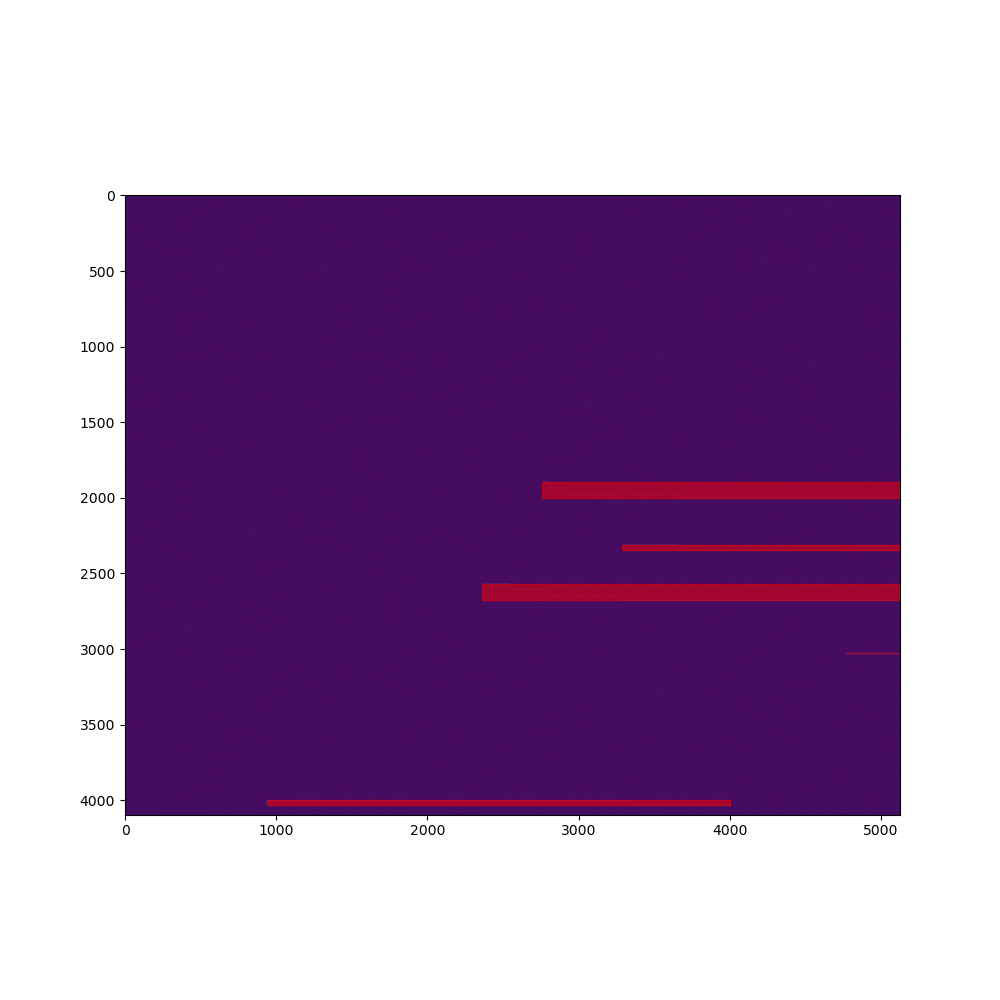

In [34]:
for i, (image, target_dict) in enumerate(zip(cres.imgs, cres.targets)):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(image[0])
    for target in target_dict['boxes']:
        width = target[2]-target[0]
        height = target[3]-target[1]
        ax.add_patch(Rectangle(target, width, height, alpha=.5, color='red'))
    plt.show()

#### Have the Dataset with proper images and targets. Now to create the DataModule

In [38]:
class CRES_DM(pl.LightningDataModule):
    """
    Self contained PyTorch Lightning DataModule for testing image
    segmentation models with PyTorch Lightning. Uses the torch dataset
    ImageSegmentation_DS.

    Args:
        train_val_size (int): total size of the training and validation
            sets combined.
        train_val_split (Tuple[float, float]): should sum to 1.0. For example
            if train_val_size = 100 and train_val_split = (0.80, 0.20)
            then the training set will contain 80 imgs and the validation
            set will contain 20 imgs.
        test_size (int): the size of the test data set.
        batch_size (int): batch size to be input to dataloaders. Applies
            for training, val, and test datasets.

    Notes: For now you can decide to shuffle the entire dataset or not but
    the train is always shuffled and the val/test isn't so you can look at
    the same images easily.
    """

    def __init__(
        self,
        root_dir,
        freq_bins=4096,
        max_pool=8,
        file_max=10,
        transform=None,
        train_val_test_splits=(0.6, 0.3, 0.1),
        batch_size=1,
        shuffle_dataset=True,
        seed=42,
        class_map={
            0: {
                "name": "background",
                "target_color": (255, 255, 255),
            },
            1: {"name": "event", "target_color": (255, 0, 0)}
        },
    ):

        super().__init__()

        # Attributes.
        self.root_dir = root_dir
        self.freq_bins = freq_bins
        self.max_pool = max_pool
        self.file_max = file_max
        self.transform = transform
        self.class_map = class_map

        self.train_val_test_splits = train_val_test_splits
        self.batch_size = batch_size
        self.shuffle_dataset = shuffle_dataset
        self.seed = seed

        self.setup()

    def setup(self, stage=None):

        self.cres_dataset = CRES_Dataset(
            self.root_dir,
            freq_bins=self.freq_bins,
            max_pool=self.max_pool,
            file_max=self.file_max,
            transform=self.transform,
        )

        # Creating data indices for training and validation splits:
        dataset_size = len(self.cres_dataset)
        indices = list(range(dataset_size))
        splits = self.train_val_test_splits
        split_idxs = [
            int(np.floor(splits[0] * dataset_size)),
            int(np.floor((splits[0] + splits[1]) * dataset_size)),
        ]

        if self.shuffle_dataset:
            rng = np.random.default_rng(self.seed)
            rng.shuffle(indices)

        train_indices, val_indices, test_indices = (
            indices[: split_idxs[0]],
            indices[split_idxs[0] : split_idxs[1]],
            indices[split_idxs[1] :],
        )

        # Creating PT data samplers and loaders. For now only train is shuffled.
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.val_sampler = torch.utils.data.SequentialSampler(val_indices)
        self.test_sampler = torch.utils.data.SequentialSampler(test_indices)

        return None

    def train_dataloader(self):
        return DataLoader(
            self.cres_dataset,
            batch_size=self.batch_size,
            sampler=self.train_sampler,
            num_workers=0,
        )

    def val_dataloader(self):
        return DataLoader(
            self.cres_dataset,
            batch_size=self.batch_size,
            sampler=self.val_sampler,
            num_workers=0,
        )

    def test_dataloader(self):
        return DataLoader(
            self.cres_dataset,
            batch_size=self.batch_size,
            sampler=self.test_sampler,
            num_workers=0,
        )


In [39]:
cres_dm = CRES_DM(root_dir=root_dir, max_pool=32)

UserWarning: No files found at the input path.

In [37]:
def get_fasterrcnn(num_classes=2, pretrained=True):
    """A function for loading the PyTorch implimentation of FasterRCNN.
    To not have predictor changed at all set num_classes = -1.
    See here for documentation on the input and output specifics:
    https://pytorch.org/vision/stable/models/faster_rcnn.html

    Args:
        num_classes (int): number of output classes desired.
        pretrained (bool): whether or not to load a model pretrained on the COCO dataset. 
    """

    # load Faster RCNN pre-trained model
    if pretrained:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    else:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

    if num_classes != -1:
        # get the number of input features
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # define a new head for the detector with required number of classes
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [159]:
def overfit(imgs, targets, model, optimizer,  device=None,  epochs= 100): 
    
    # model = model.to(device)
    model.train()

    # Formatting for input to model. 
    imgs_normed = imgs / 255.0
    # imgs_normed = imgs_normed.to(device)
    # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    

    for epoch in range(epochs):

        loss_dict = model(imgs_normed, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if epoch %25 == 0:
            print(f"epoch: {epoch}")
            print(f"loss {losses:.4f}\n")

    return None

In [35]:
cres_dm.setup(stage = "fit")
dataiter = iter(cres_dm.train_dataloader())

imgs, targets = dataiter.next()

print(f"Input shape:\n {imgs.shape} \n" )

print(f"Faster RCNN target for img 0:\n ")
for key, val in targets.items():
    print(f"{key}:\n {val}")

NameError: name 'cres_dm' is not defined

In [162]:
model = get_fasterrcnn(num_classes = 2, pretrained = True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
overfit(cres_dm.cres_dataset.imgs[:2], cres_dm.cres_dataset.targets[:2], model, optimizer,  epochs=400)

epoch: 0
loss 9.7149

epoch: 25
loss 0.9379

epoch: 50
loss 0.6982

epoch: 75
loss 0.4322

epoch: 100
loss 0.2534

epoch: 125
loss 0.0909

epoch: 150
loss 0.1614

epoch: 175
loss 0.0958

epoch: 200
loss 0.0574

epoch: 225
loss 0.0609

epoch: 250
loss 0.0433

epoch: 275
loss 0.0508

epoch: 300
loss 0.0398

epoch: 325
loss 0.0385

epoch: 350
loss 0.0536

epoch: 375
loss 0.0344



In [132]:
def apply_score_cut(preds, score_threshold=0.5):
    """
    Takes a list of prediction dictionaries (one for each image) and cuts
    out all instances whose score is below the score threshold.

    Args:
        preds (List[Dict[torch.Tensor]]): predictions as output by the
            torchvision implimentation of MaskRCNN or FasterRCNN. The 
            scores are in the range (0,1) and signify the certainty of 
            the model for that instance.
            See link below for details on the target/prediction formatting.
            https://pytorch.org/vision/0.12/_modules/torchvision/models/detection/mask_rcnn.html
        score_threshold (float): the threshold to apply to the identified
            objects. If an instance is below the score_threshold it will
            be removed from the score_thresholded_preds dictionary.

    Returns:
        score_thresholded_preds (List[Dict[torch.Tensor]]): predictions
            that exceed score_threshold.
    """
    score_thresholded_preds = [
        {key: value[pred["scores"] > score_threshold] for key, value in pred.items()}
        for pred in preds
    ]

    return score_thresholded_preds

In [163]:
model.eval()
preds = model(cres_dm.cres_dataset.imgs[2:]/255.)
preds = apply_score_cut(preds, score_threshold=0.5)
preds

[{'boxes': tensor([[110.4715,  66.5061, 158.3730,  66.7226],
          [ 11.7722,  98.5119,  72.0020,  98.8714],
          [ 85.5772,  66.0948, 160.0000,  67.3616],
          [  7.2739,  98.2499, 109.3806,  99.7939]], grad_fn=<IndexBackward0>),
  'labels': tensor([1, 1, 1, 1]),
  'scores': tensor([0.9881, 0.9838, 0.9796, 0.9664], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[ 53.7002, 113.4154, 160.0000, 114.7490],
          [ 97.5648,  87.1532, 156.5750,  87.4319]], grad_fn=<IndexBackward0>),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9842, 0.8704], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[110.3832, 115.1734, 159.6727, 115.4414],
          [112.0452, 114.9112, 159.4523, 116.3446]], grad_fn=<IndexBackward0>),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9975, 0.9859], grad_fn=<IndexBackward0>)}]

In [205]:
def show(imgs, figsize=(10.0, 10.0)):
    """Displays a single image or list of images. Taken more or less from
    the pytorch docs:
    https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html#visualizing-a-grid-of-images

    Args:
        imgs (Union[List[torch.Tensor], torch.Tensor]): A list of images
            of shape (3, H, W) or a single image of shape (3, H, W).
        figsize (Tuple[float, float]): size of figure to display.

    Returns:
        None
    """

    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), figsize=figsize, squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

    return None

def display_boxes(imgs, target_pred_dict, class_map, width = 1, fill=False):
    """
    Takes a list of images and a list of target or prediction dictionaries
    of the same len and overlays bounding boxes onto the images.

    Args:
        imgs (List[torch.ByteTensor[3, H, W]]): list of images (each a
            torch.ByteTensor of shape(3, H, W)).

        target_pred_dict (List[Dict[torch.Tensor]]): predictions or targets
            formatted according to the torchvision implimentation of
            FasterRCNN and MaskRCNN.
            See link below for details on the target/prediction formatting.
            https://pytorch.org/vision/0.12/_modules/torchvision/models/detection/mask_rcnn.html

        class_map (Dict[Dict]): the class map must contain keys that
            correspond to the labels provided. Inner Dict must contain
            key "target_color". class 0 is reserved for background.
            A valid example ("name" not necessary):
            class_map={
            0: {"name": "background","target_color": (255, 255, 255),},
            1: {"name": "rectangle", "target_color": (255, 0, 0)},
            2: {"name": "line", "target_color": (0, 255, 0)},
            3: {"name": "donut", "target_color": (0, 0, 255)}}.

        fill (bool): if True the inside of the bounding boxes will be
            filled with color.

    Returns:
        result_imgs (List[torch.ByteTensor[3, H, W]]): list of images with
            overlaid bounding boxes.
    """
    num_imgs = len(imgs)
    result_imgs = [
        draw_bounding_boxes(
            imgs[i].type(torch.uint8),
            target_pred_dict[i]["boxes"].int(),
            fill=fill,
            colors=[
                class_map[j.item()]["target_color"]
                for j in target_pred_dict[i]["labels"]
            ],
            width=width,
        )
        for i in range(num_imgs)
    ]

    return result_imgs

In [206]:
%matplotlib inline
@widgets.interact
def vizualize_targets_predictions(
                                target_box = widgets.Checkbox(value=False,description='target boxes'),
                                pred_box = widgets.Checkbox(value=False,description='prediction boxes'),
                                display_size = widgets.IntSlider(value=10,min=2,max=50,step=1)
                                ): 

    # result_image = [imgs[i] for i in range(len(preds))]
    result_image = cres_dm.cres_dataset.imgs[2:]/255.
    for target in cres_dm.cres_dataset.targets:
        target['boxes'] = target['boxes'].long()
    targets = cres_dm.cres_dataset.targets[2:]

    if target_box: 
        result_image = display_boxes(result_image, targets, cres_dm.class_map, fill = True)
    if pred_box: 
        result_image = display_boxes(result_image, preds, cres_dm.class_map)

    grid = make_grid(result_image)
    show(grid, figsize = (display_size,display_size))

interactive(children=(Checkbox(value=False, description='target boxes'), Checkbox(value=False, description='pr…

In [204]:
cres_dm.cres_dataset.imgs[2:].shape

torch.Size([3, 1, 128, 160])